# Dataset Augmentation using Stable Diffusion for Better Generalization

## Requirements

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install numpy accelerate opencv-python pandas matplotlib ultralytics diffusers transformers datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u2qicx9h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u2qicx9h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import os
from PIL import Image

import torch
import numpy as np
from segment_anything import build_sam, SamPredictor
from ultralytics import YOLO
from diffusers import StableDiffusionInpaintPipeline

/home/saad.ashraf/miniconda3/envs/diff-dg/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/saad.ashraf/miniconda3/envs/diff-dg/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
WORKING_DIR = os.getcwd()
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIR, "weights")
ASSETS_DIRECTORY = os.path.join(WORKING_DIR, "assets")

In [5]:
if not os.path.exists(WEIGHTS_DIRECTORY):
    os.mkdir(WEIGHTS_DIRECTORY)

if not os.path.exists(ASSETS_DIRECTORY):
    os.mkdir(ASSETS_DIRECTORY)

In [6]:
SEGMENTATION_MODEL_KEY = os.path.join(WEIGHTS_DIRECTORY, "sam_vit_h_4b8939.pth")
DIFFUSION_MODEL_KEY = "stabilityai/stable-diffusion-2-inpainting"
DETECTION_MODEL_KEY = "yolov8s.pt"

In [7]:
!wget -nc -O "$SEGMENTATION_MODEL_KEY" https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-23 13:45:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/home/saad.ashraf/classwork/first_sem/ensf/tutorial_assignment/DiffusedDG/weights/sam_vit_h_4b8939.pth’

/home/saad.ashraf/c 100%[===================>]   2.39G  93.2MB/s    in 28s     

2024-02-23 13:45:36 (88.8 MB/s) - ‘/home/saad.ashraf/classwork/first_sem/ensf/tutorial_assignment/DiffusedDG/weights/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Load Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Cat_and_Dog")

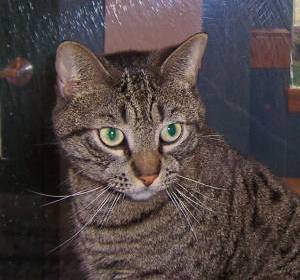

In [8]:
dataset["train"][0]["image"]

# Generator

In [9]:
from typing import Dict, List


class Generator:
    def __init__(self, detection_model: str, segmentation_model: str, diffusion_model: str, device: str = "cuda") -> None:
        self._detection_model = YOLO(detection_model)
        self._segmentation_model = SamPredictor(build_sam(checkpoint=segmentation_model).to(device))
        self._sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
            diffusion_model,
            torch_dtype=torch.float16 if device=="cuda" else torch.float32,
        ).to(device)
        self._device = device

    def detect(self, image: Image) -> List[Dict]:
        results = self._detection_model(image)

        # Extract bounding boxes, classes, names, and confidences
        boxes = results[0].boxes.xyxy.tolist()
        classes = results[0].boxes.cls.tolist()
        names = results[0].names
        confidences = results[0].boxes.conf.tolist()

        formatted_result = []

        # Iterate through the results
        for box, class_id, conf in zip(boxes, classes, confidences):
            name = names[int(class_id)]
            formatted_result.append(
                {"class": name, "class_id": class_id, "bbox": box, "confidence": conf}
            )

        return formatted_result

    def segment(self, image: Image, boxes: List):
        image_np = np.asarray(image)
        self._segmentation_model.set_image(image_np)
        H, W, _ = image_np.shape
        boxes_xyxy = torch.as_tensor(boxes)

        transformed_boxes = self._segmentation_model.transform.apply_boxes_torch(boxes_xyxy.to(self._device), image_np.shape[:2])
        masks, _, _ = self._segmentation_model.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
            )
        return masks.cpu()

    def draw_mask(self, mask, image, random_color=True) -> np.array:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.2])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

        annotated_frame_pil = image.convert("RGBA")
        mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

        return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

    def generate_image(self, image: Image, prompt: str, negative_prompt: str, seed: int = 42, inverted: bool = True) -> Dict:
        detection_result = self.detect(image)
        detected_boxes = [det["bbox"] for det in detection_result]
        segmented_frame_masks = self.segment(image, boxes=detected_boxes)
        annotated_frame_with_mask = self.draw_mask(segmented_frame_masks[0][0], image)

        mask = segmented_frame_masks[0][0].cpu().numpy()
        inverted_mask = ((1 - mask) * 255).astype(np.uint8)
        mask = Image.fromarray(mask)
        inverted_mask = Image.fromarray(inverted_mask)


        # resize for inpainting
        w, h = image.size
        in_image = image.resize((512, 512))
        in_mask = inverted_mask.resize((512, 512)) if inverted else mask.resize((512, 512))

        generator = torch.Generator(self._device).manual_seed(seed)

        sd_result = self._sd_pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
        sd_result = sd_result.images[0]

        results = {
            "detection_result": detection_result,
            "mask": in_mask,
            "annotated_frame_mask": annotated_frame_with_mask,
            "generated_image": sd_result.resize((w, h)),
        }

        return results


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
gen = Generator(
    detection_model=DETECTION_MODEL_KEY,
    segmentation_model=SEGMENTATION_MODEL_KEY,
    diffusion_model=DIFFUSION_MODEL_KEY,
    device=device
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 159MB/s]


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
sample_image = dataset["train"][580]["image"]

In [13]:
result = gen.generate_image(sample_image, "mountains landscape", "low resolution, ugly", -1, True)


0: 512x640 3 cats, 120.4ms
Speed: 87.2ms preprocess, 120.4ms inference, 845.9ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 0/50 [00:00<?, ?it/s]

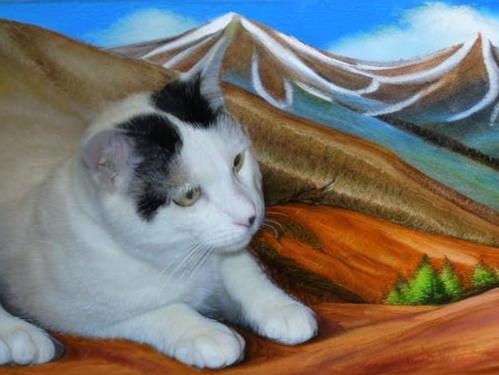

In [14]:
result["generated_image"]

#Classifier

In [4]:
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

In [5]:
# Data Preparation

print(dataset["train"].filter(lambda x: x["labels"] == 0))
print(dataset["train"].filter(lambda x: x["labels"] == 1))
print(dataset["test"].filter(lambda x: x["labels"] == 0))
print(dataset["test"].filter(lambda x: x["labels"] == 1))

Dataset({
    features: ['image', 'labels'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 1000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 1000
})


In [6]:
shuffled_train_dataset = dataset["train"].shuffle(seed=42)
shuffled_test_dataset = dataset["test"].shuffle(seed=42)

In [7]:
train_dataset = shuffled_train_dataset.select(range(1800))
val_dataset = shuffled_train_dataset.select(range(1800, 2000))
test_dataset = shuffled_test_dataset.select(range(100))

In [8]:
class HuggingFaceDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),  # Convert PIL image to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Assuming the path to the image is stored under the key 'file'
        image = self.transforms(image)
        # Assuming there's a key 'label' in the sample dict for the label
        label = torch.tensor(sample['labels'], dtype=torch.float)
        return image, label

In [9]:
# Example usage:
# Assuming 'huggingface_dataset' is your dataset obtained from Hugging Face
torch_train_dataset = HuggingFaceDataset(train_dataset)
torch_val_dataset = HuggingFaceDataset(val_dataset)
torch_test_dataset = HuggingFaceDataset(test_dataset)

In [10]:
batch_size = 32

In [26]:
train_dl = DataLoader(torch_train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(torch_val_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(torch_test_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

/home/saad.ashraf/miniconda3/envs/diff-dg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


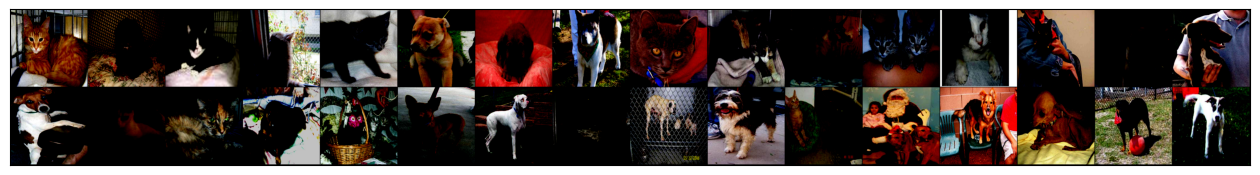

In [12]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    images, labels = next(iter(dl))
    fig,ax = plt.subplots(figsize = (16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))


show_batch(train_dl)
# type(train_ds)

In [13]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        out = out.squeeze(dim=1)
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        out = out.squeeze(dim=1)
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class DogsvsCatsClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(262144,1),
            nn.Sigmoid(),
        )

    def forward(self, xb):
        return self.network(xb)

In [20]:
def accuracy(outputs, labels):
    preds = (outputs >= 0.5).float()
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [21]:
model = DogsvsCatsClassifier()

In [22]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch [0], train_loss: 0.7696, val_loss: 0.6898, val_acc: 0.5670


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [1], train_loss: 0.6636, val_loss: 0.6475, val_acc: 0.6250


100%|██████████| 57/57 [02:09<00:00,  2.28s/it]


Epoch [2], train_loss: 0.6224, val_loss: 0.6337, val_acc: 0.6562


100%|██████████| 57/57 [02:09<00:00,  2.28s/it]


Epoch [3], train_loss: 0.5657, val_loss: 0.5986, val_acc: 0.6786


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [4], train_loss: 0.4858, val_loss: 0.5911, val_acc: 0.6607


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [5], train_loss: 0.4077, val_loss: 0.7428, val_acc: 0.6473


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [6], train_loss: 0.3253, val_loss: 0.5615, val_acc: 0.7455


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [7], train_loss: 0.1998, val_loss: 0.6627, val_acc: 0.7277


100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch [8], train_loss: 0.1201, val_loss: 0.7391, val_acc: 0.7411


100%|██████████| 57/57 [02:09<00:00,  2.28s/it]


Epoch [9], train_loss: 0.0563, val_loss: 0.9580, val_acc: 0.6473


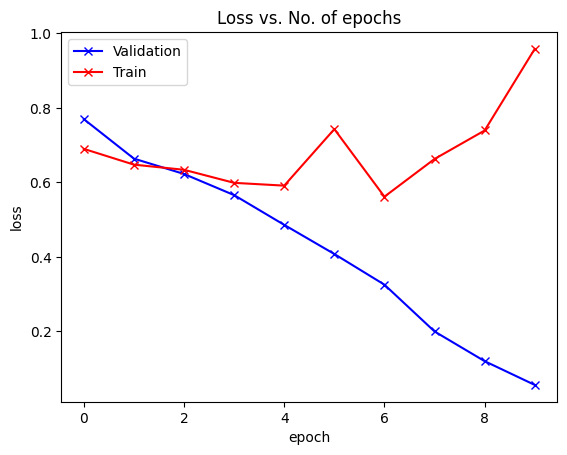

In [25]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

# plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Validation', 'Train'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [28]:
outputs = evaluate(model, test_dl)

/home/saad.ashraf/miniconda3/envs/diff-dg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
outputs

{'val_loss': 1.0678894519805908, 'val_acc': 0.6953125}